In this code example, we'll apply time-varying LQR feedback control to stabilize a 2D quadrotor along a trajectory.

In [1]:
%pylab inline
from pylab import *

import control
import matplotlib.animation
import scipy.integrate

rc("animation", html="html5")

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils       as curve_utils
import flashlight.interpolate_utils as interpolate_utils
import flashlight.quadrotor_2d      as quadrotor_2d
import flashlight.spline_utils      as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_2d: Constructing sympy symbols...
flashlight.quadrotor_2d: Finished constructing sympy symbols (0.005 seconds).
flashlight.quadrotor_2d: Loading sympy modules...
flashlight.quadrotor_2d: Finished loading sympy modules (0.004 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


We begin by computing our intended trajectory exactly as in the previous examples.

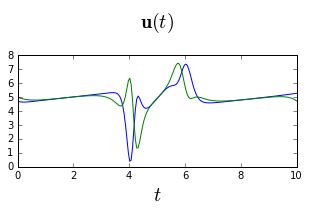

In [2]:
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_y, T_x]
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

t = linspace(0.0,10.0,num_samples)
s_spline = P_s_eval

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

p  = P_eval_spline
dt = (t_end-t_begin) / num_timesteps

q_qdot_qdotdot = quadrotor_2d.compute_state_space_trajectory_and_derivatives(p, dt)
u              = quadrotor_2d.compute_control_trajectory(q_qdot_qdotdot)

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

Next, we set up our simulation callback function to compute the appropriate feedback control forces and compute the time derivative of our quadrotor state. Our time-varying LQR control strategy here is similar to the LQR control strategy in our previous example. However, in this example, our linearization point varies with time. Instead of linearizing about hovering-at-the-origin, we linearize about a point that moves along our intended trajectory. Notice how applying time-varying LQR completely eliminates the drift away from our intended trajectory, which was an issue in our previous code example. For more details on time-varying LQR, see [1].

#### References

[1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (course notes for MIT 6.832). 2016. http://underactuated.mit.edu

In [3]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_2d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)

u_nominal = u

x_0 = x_nominal[0]

Q = diag([1,1,1,1,1,1])
R = diag([1,1])

def compute_x_dot(x_t, t):

    x_t = matrix(x_t).T
    
    x_nominal_t = x_nominal_interp_func(clip(t, t_begin, t_end))
    u_nominal_t = u_nominal_interp_func(clip(t, t_begin, t_end))
    
    A_t, B_t      = quadrotor_2d.compute_df_dx_and_df_du(x_nominal_t, u_nominal_t)
    K_t, S_t, E_t = control.lqr(A_t, B_t, Q, R)
    
    x_bar_t = x_t - x_nominal_t
    u_bar_t = -K_t*x_bar_t
    u_t     = u_bar_t + u_nominal_t
    x_dot_t = quadrotor_2d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim     = 200
t_sim                 = linspace(t_begin, t_end, num_timesteps_sim)
x_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, x_nominal, kind="cubic")
u_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, u_nominal, kind="cubic")
x_sim                 = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

figsize(9,4)
quadrotor_2d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, inline=True)

Finally, we can also specify the initial state of our simulation to have a large initial velocity, to simulate a large unexpected disturbance (e.g., a gust of wind) occuring at the beginning of the simulation. Notice how applying time-varying LQR successfully attracts the quadrotor back to our intended trajectory.

In [4]:
x_disturbance = matrix([0.0, 0.0, 0.0, 5.0, 5.0, -4.0*pi]).T
x_0           = (matrix(x_nominal[0]).T + x_disturbance).A1
x_sim         = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

figsize(9,4)
quadrotor_2d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, inline=True)